# Self-Driving Car Engineer Nanodegree

## Deep Learning - Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Random sample images:


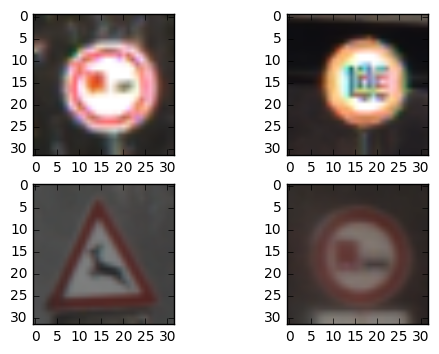

In [3]:
### Data exploration visualization
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
print('Random sample images:')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X_train[randint(0,34000)])

[]

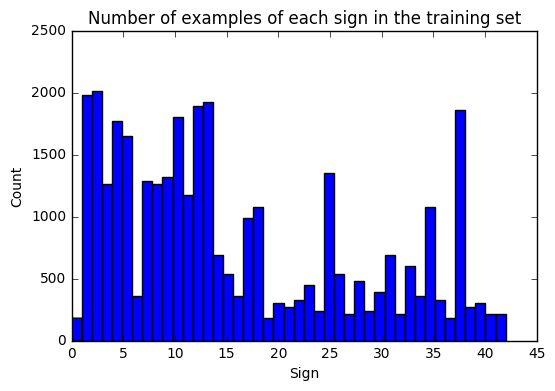

In [4]:
plt.hist(y_train, bins=n_classes)
plt.title('Number of examples of each sign in the training set')
plt.xlabel('Sign')
plt.ylabel('Count')
plt.plot()

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set

#### Normalize the dataset to prevent overfitting:

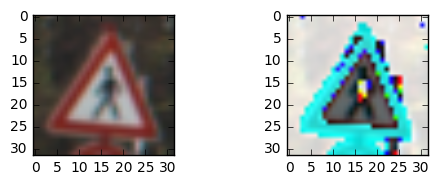

In [5]:
import numpy as np

# Save original set
X_train_raw = X_train
X_test_raw = X_test

# Normalise input (images still in colour)
X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))

"""Plots original image on the left an{d normalised image on the right."""
random_image = randint(0,30000)
plt.subplot(2,2,1)
plt.imshow(X_train_raw[random_image])
plt.subplot(2,2,2)
plt.imshow(X_train[random_image])

#### Shuffle/split the data

In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### One hot encoding

In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

encoder = preprocessing.LabelBinarizer()
y_train_onehot = encoder.fit_transform(y_train)
y_test_onehot = encoder.fit_transform(y_test)

### Model Architecture

The LeNet architecture is used to train the classifier on the German Traffic Sign dataset. The following steps are outlined below.

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 5x5x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 5x5x32. Output = 14x14x512.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x512.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 800.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = fc0 shape. Output = 1024.
    fc1_shape = (fc0.get_shape().as_list()[-1], 512)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 512. Output = 128.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Output
    output_W = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    output_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, output_W) + output_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [9]:
# NN parameters
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.001

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y_rawlabels = tf.placeholder("int32", [None])
y = tf.one_hot(y_rawlabels, depth=43, on_value=1., off_value=0., axis=-1)

In [11]:
# Run LeNet
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Performance metrics
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y_rawlabels: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y_rawlabels: batch_y})
            
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.875

EPOCH 2 ...
Validation Accuracy = 0.942

EPOCH 3 ...
Validation Accuracy = 0.964

EPOCH 4 ...
Validation Accuracy = 0.972

EPOCH 5 ...
Validation Accuracy = 0.978

EPOCH 6 ...
Validation Accuracy = 0.974

EPOCH 7 ...
Validation Accuracy = 0.982

EPOCH 8 ...
Validation Accuracy = 0.973

EPOCH 9 ...
Validation Accuracy = 0.981

EPOCH 10 ...
Validation Accuracy = 0.976

Model saved


---

## Step 3: Test a Model on New Images

To show how the model is working in the real world, 5 random images have been downloaded from google.

In [ ]:
import os
import scipy.misc

NEW_IMAGES_FOLDER = './test_images/'


def resize_image(image_file):
    image = plt.imread(NEW_IMAGES_FOLDER + image_file)
    return scipy.misc.imresize(image, (128, 128))

resized_image_data = [(resize_image(image), image[:-4]) 
                          for image in os.listdir(NEW_IMAGES_FOLDER)]

def display_images(imgs_data):
    index = 1
    plt.figure(figsize=(4,9))
    for img, name in imgs_data:
        plt.subplot(5, 1, index)
        plt.imshow(img)
        plt.axis('off')
        plt.title(name)
        index += 1
    plt.show()
    
display_images(resized_image_data)

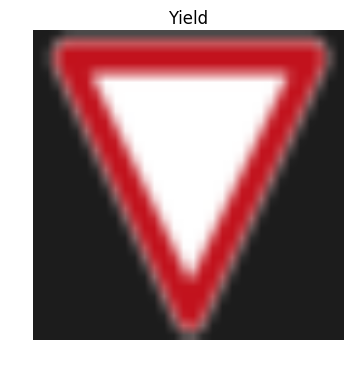

CNN Prediction:  ['Yield'] (13)
Top Results:  [[ 1.  0.  0.  0.  0.]]
Top Indices:  [[13  0  1  2  3]]


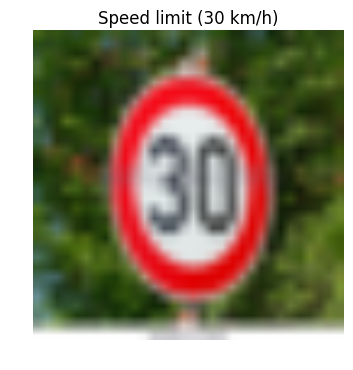

CNN Prediction:  ['Speed limit (30km/h)'] (1)
Top Results:  [[ 1.  0.  0.  0.  0.]]
Top Indices:  [[1 0 2 3 4]]


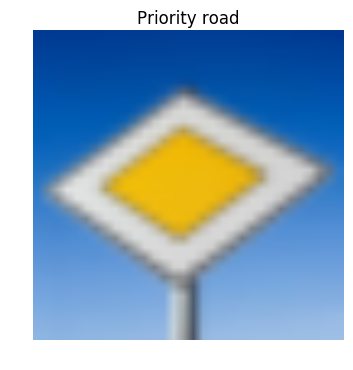

CNN Prediction:  ['Priority road'] (12)
Top Results:  [[ 1.  0.  0.  0.  0.]]
Top Indices:  [[12  0  1  2  3]]


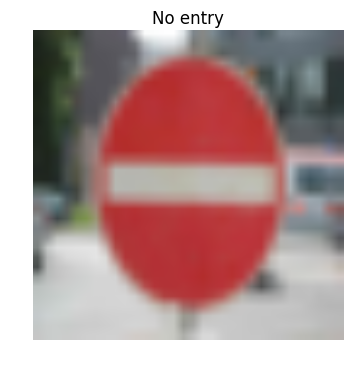

CNN Prediction:  ['No entry'] (17)
Top Results:  [[ 1.  0.  0.  0.  0.]]
Top Indices:  [[17  0  1  2  3]]


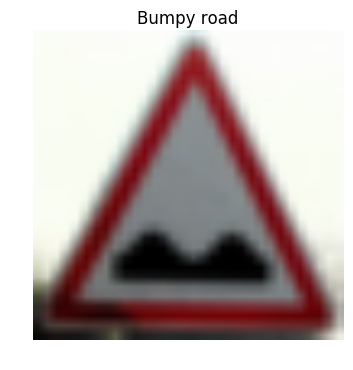

CNN Prediction:  ['Bumpy road'] (22)
Top Results:  [[ 1.  0.  0.  0.  0.]]
Top Indices:  [[22  0  1  2  3]]


In [58]:
import os
import scipy.misc

import csv
reader = csv.reader(open('signname.csv'))

result = {}
for row in reader:
    key = row[0]
    if key in result:
        # implement your duplicate row handling here
        pass
    result[key] = row[1:]

NEW_IMAGES_FOLDER = './test_images/'

labels = {0: 'Yield',
          1: 'Speed limit (30 km/h)',
          2: 'Priority road',
          3: 'No entry',
          4: 'Bumpy road'}

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for i in range(5):
        image = plt.imread(NEW_IMAGES_FOLDER + str(i)+'.jpg')
        image = scipy.misc.imresize(image, (32, 32))
        
        plt.imshow(image)
        plt.axis('off')
        plt.title(labels[i])
        plt.show()
        
        classification = sess.run(tf.argmax(logits, 1), feed_dict={x: [image]})
        softmax = tf.nn.softmax(logits)        
        normalized_prob = sess.run(softmax, feed_dict={x: [image]})
        top_k_op = tf.nn.top_k(normalized_prob, k=5)
        top_k_results = sess.run(top_k_op)
        
        print('CNN Prediction: ', result[str(classification[0])], '('+str(classification[0])+')')
        print('Top Results: ', top_k_results.values)
        print('Top Indices: ', top_k_results.indices)

### Analyze Performance

The CNN was able to predict all 5 images from google correctly with 100% accuracy. 🎉

The top result was always chosen with a 100% probability.